# **CNN-based Rice Variety Classification with PyTorch**

# Introduction
In recent years, the use of machine learning and deep learning techniques in agriculture has gained significant attention. One of the key areas where these technologies are being applied is in the classification of various agricultural products, such as rice. Rice is one of the most important staple foods in the world, and accurate identification and classification of different rice varieties are crucial for ensuring food quality, optimizing agricultural practices, and enhancing supply chain management.

This project focuses on the classification of rice varieties using Convolutional Neural Networks (CNNs), a deep learning architecture known for its powerful capabilities in image recognition tasks. The goal of this project is to develop a robust model capable of accurately distinguishing between different rice varieties based on their images. The CNN model is trained on a dataset of rice images, and the results are evaluated using metrics such as accuracy, loss, and confusion matrix. This evaluation provides insights into the performance of the model in terms of its ability to correctly classify unseen images of rice varieties.

The project utilizes popular deep learning libraries such as PyTorch for building and training the model. The model architecture includes convolutional layers for feature extraction, pooling layers for dimensionality reduction, and fully connected layers for classification. Additionally, batch normalization is applied to stabilize the learning process and improve generalization.

By leveraging state-of-the-art techniques in image classification, this project aims to contribute to the agricultural sector by offering a machine learning-based solution for the automatic classification of rice varieties, thus reducing the dependency on manual inspection and improving efficiency in agricultural processes.



# Import Libraries
Here we import the essential libraries required for the project

In [1]:
!pip install split-folders
import warnings
warnings.filterwarnings('ignore')
import os    
import cv2
import time
import torch 
import shutil
import random 
import pathlib 
import torchvision     
import numpy as np  
import pandas as pd 
import splitfolders 
import torch.nn as nn   
import seaborn as sns   
from tqdm import tqdm  
import torch.utils.data
import torch.optim as optim  
from tabulate import tabulate
from datetime import datetime  
from termcolor import colored 
import torch.nn.functional as F
import matplotlib.pyplot as plt  
from torchsummary import summary
from IPython.display import display
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style('whitegrid')


# Load Data and Define Classes¶
In this section, we specify the directory where the rice image dataset is located. Then, we list all the classes (subdirectories) within this directory, representing different rice varieties. The list of classes is generated dynamically by reading the folder names in the dataset directory. We also remove the 'Rice_Citation_Request.txt' file from the list as it's not a class.

The list of rice varieties (classes) is then printed to verify the available categories.

In [2]:
output_dir = '/kaggle/working/rice_image_dataset_split'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')


for folder in [train_dir, val_dir, test_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Delete all contents of the folder


In [3]:
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
classes  = [class_name for class_name in os.listdir(data_dir) if class_name]
classes .remove('Rice_Citation_Request.txt')
print(classes)

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


## Display Sample Images from Each Class¶
In this section, we define a function show_samples to visualize a few sample images from each rice variety class in the dataset. For each class, we randomly select 6 images and display them in a horizontal grid.

We use OpenCV to read the images and Matplotlib to display them. The images are converted from BGR (OpenCV default) to RGB format for correct color display in Matplotlib.

This helps to get an overview of the dataset and visually inspect the variety of images in each class.

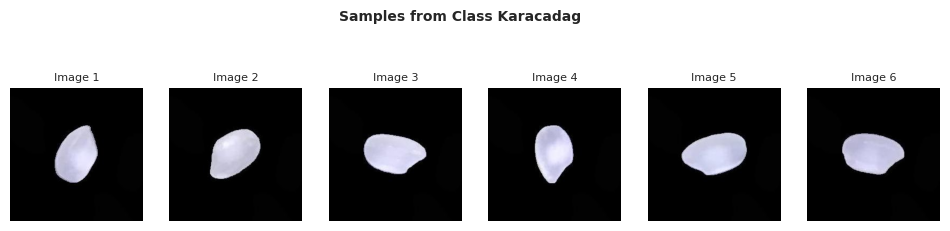

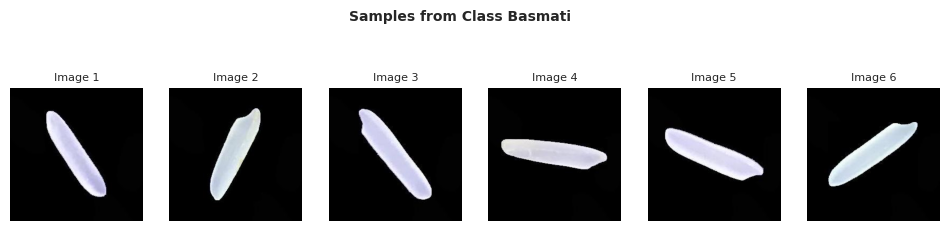

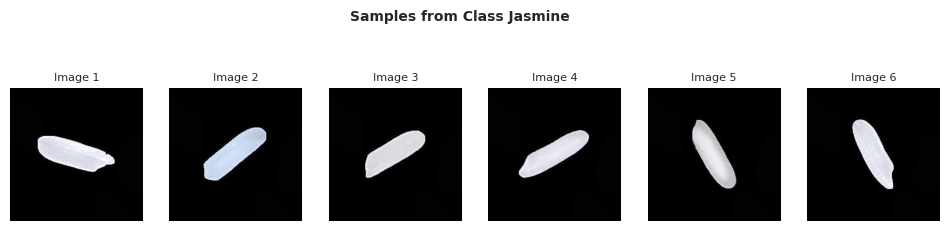

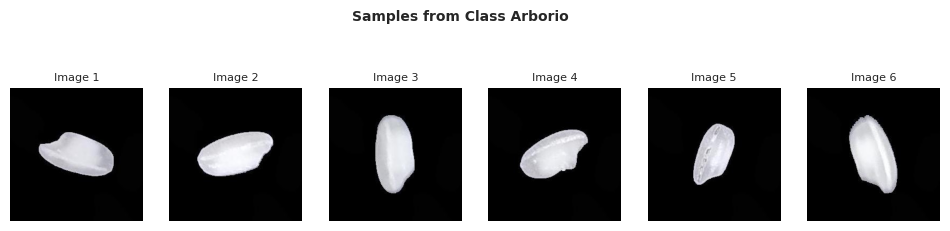

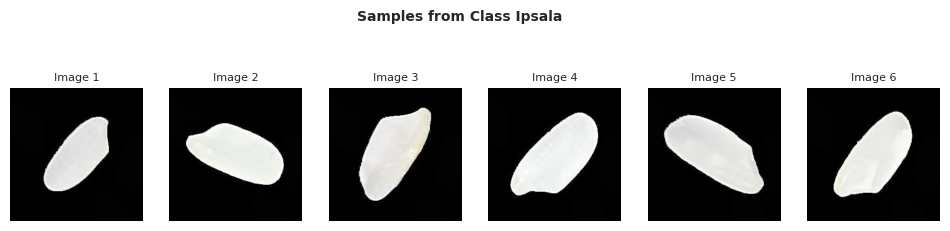

In [4]:
def show_samples(data_dir, classes):
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        images_in_class = os.listdir(class_path)
        sample_images = random.choices(images_in_class, k=6)

        fig, ax = plt.subplots(1, 6, figsize=(12, 3))
        plt.suptitle(f'Samples from Class {class_name}', fontsize= 10, fontweight='bold')

        for i in range(6):
            img_path = os.path.join(class_path, sample_images[i])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            ax[i].imshow(img)
            ax[i].axis('off')
            ax[i].set_title(f'Image {i + 1}', fontsize=8)

        plt.show()

show_samples(data_dir, classes)

# Splitting the Dataset into Training, Validation, and Test Sets
In this part of the code, the rice image dataset is split into three subsets: training (70%), validation (20%), and test (10%). This is done using the splitfolders library, which allows easy splitting of the data based on the specified ratios.

Data Directory: The path to the original dataset is defined.
Data Splitting: The splitfolders.ratio function is used to split the data into the specified proportions. Here, 70% of the data is allocated for training, 20% for validation, and 10% for testing.
New Data Paths: After splitting, the new paths for the training, validation, and test datasets are assigned to different variables.
Printing Paths: Finally, the paths to the split datasets are printed to ensure that the splitting operation was successful.
This step prepares the data for model training and evaluation in the following stages.

In [5]:
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
output_dir = '/kaggle/working/rice_image_dataset_split'

splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.7, .2, .1))  # 70% for training, 20% for validation, 10% for testing

train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

print(f"Training data: {train_dir}")
print(f"Validation data: {val_dir}")
print(f"Test data: {test_dir}")

Copying files: 75000 files [18:59, 65.80 files/s] 

Training data: /kaggle/working/rice_image_dataset_split/train
Validation data: /kaggle/working/rice_image_dataset_split/val
Test data: /kaggle/working/rice_image_dataset_split/test


# Data Preprocessing and Loading
In this section of the code, we perform several important tasks related to the preparation of the rice image dataset for training the model.

Defining Transforms:

The transform object is created using transforms.Compose to define a series of preprocessing steps for the images.
Resize: The images are resized to a fixed size of 256x256 pixels.
ToTensor: Converts the images to tensor format, which is compatible with PyTorch models.
Normalize: The images are normalized using the mean and standard deviation values for RGB images (the typical values for pre-trained models like ResNet).
Loading the Datasets:

datasets.ImageFolder is used to load the images from the specified directories (train_dir, val_dir, test_dir), applying the defined transformations (transform) on each image.
Creating DataLoaders:

DataLoader: A DataLoader is created for each dataset (training, validation, and test). This allows us to efficiently load the data in batches during model training and evaluation.
batch_size=32 defines how many images to load in each batch.
shuffle=True ensures that the training data is shuffled, providing randomness during training, while the validation and test sets are not shuffled (shuffle=False).
Displaying a Sample:

A sample of the training data is retrieved using next(data_iter). This provides a batch of images and their corresponding labels.
The shapes of the images and labels in the batch are printed to verify the structure of the data.
This process ensures that the dataset is ready for use in training the deep learning model, with proper preprocessing and data loading mechanisms.



In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # For color images (RGB)
])

# Loading data
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create a DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Show sample data
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Sample image batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")

Sample image batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


## Counting the Number of Images in Each Class
In this section of the code, we define a function that counts the number of images in each class of the training, validation, and test datasets. This helps us verify how well the data is distributed across different classes and datasets.

Path Setup:

We define the paths for the training, validation, and test directories where the images are stored. These directories are the result of the previous data split.
Function Definition (count_images_in_dir):

This function takes a directory path as input and counts the number of images in each class within the directory.
os.listdir(directory): This command lists the contents of the specified directory (in this case, the subdirectories representing different classes).
Looping Through Classes: For each class (subdirectory), the function checks if it’s a directory and counts the number of images inside using len(os.listdir(class_path)).
The function returns a dictionary with class names as keys and the number of images as values.
Displaying the Counts:

The function is called for each of the three datasets (train, validation, and test) and the results are printed out, showing how many images are in each class for each dataset.

In [7]:
train_dir = '/kaggle/working/rice_image_dataset_split/train'
val_dir = '/kaggle/working/rice_image_dataset_split/val'
test_dir = '/kaggle/working/rice_image_dataset_split/test'

# A function to count the number of images in each class
def count_images_in_dir(directory):
    classes = os.listdir(directory)
    image_counts = {}
    
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_counts[class_name] = len(os.listdir(class_path))
    
    return image_counts

# Show the number of images in each folder
print("Train set image count:")
train_counts = count_images_in_dir(train_dir)
print(train_counts)

print("\nValidation set image count:")
val_counts = count_images_in_dir(val_dir)
print(val_counts)

print("\nTest set image count:")
test_counts = count_images_in_dir(test_dir)
print(test_counts)

Train set image count:
{'Ipsala': 10500, 'Jasmine': 10500, 'Basmati': 10500, 'Karacadag': 10500, 'Arborio': 10500}

Validation set image count:
{'Ipsala': 3000, 'Jasmine': 3000, 'Basmati': 3000, 'Karacadag': 3000, 'Arborio': 3000}

Test set image count:
{'Ipsala': 1500, 'Jasmine': 1500, 'Basmati': 1500, 'Karacadag': 1500, 'Arborio': 1500}


## Plotting the Image Distribution in the Train, Validation, and Test Sets
In this section of the code, we visualize the distribution of images across different classes for the training, validation, and test datasets using two types of plots: bar charts and pie charts.

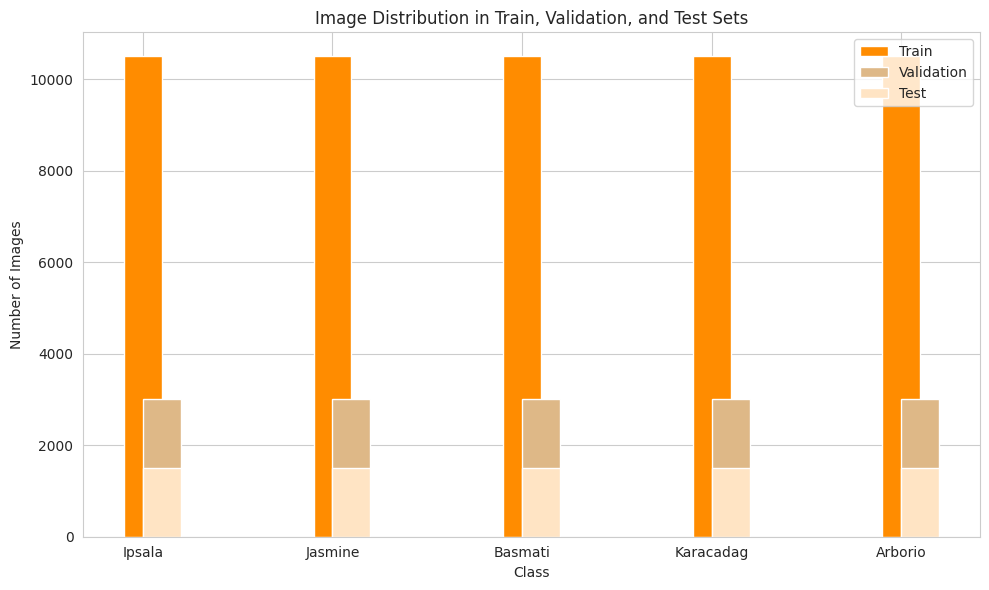

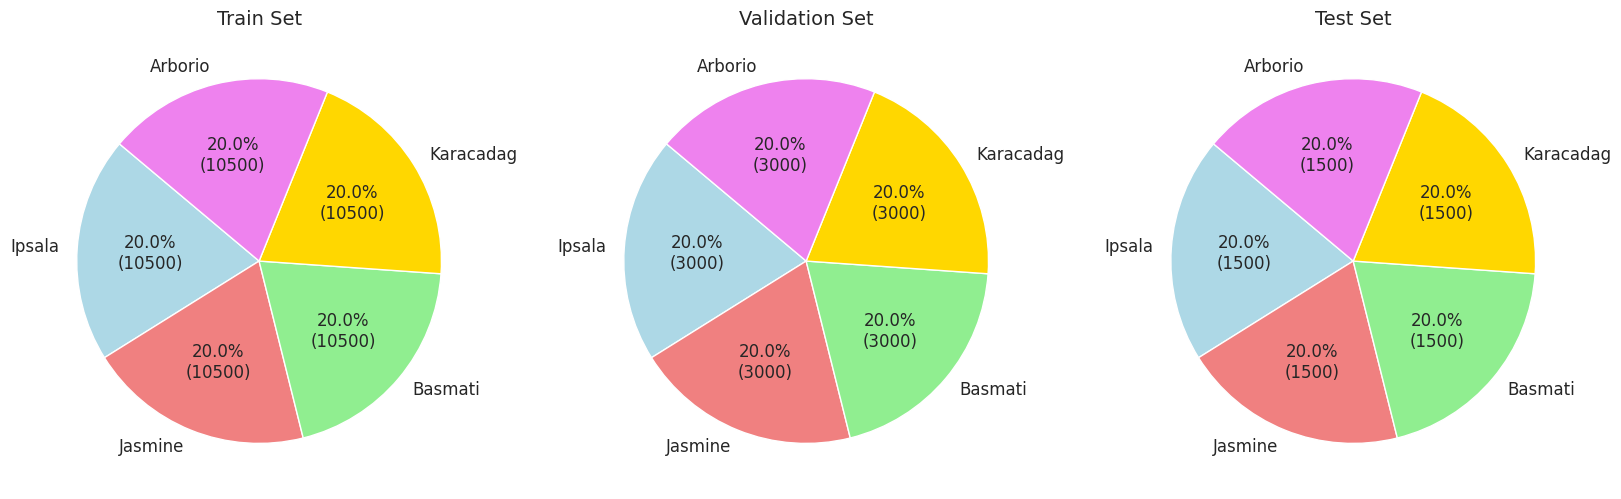

In [8]:
def plot_image_counts(train_counts, val_counts, test_counts):
    # Prepare data for plotting
    categories = list(train_counts.keys())
    train_values = list(train_counts.values())
    val_values = list(val_counts.values())
    test_values = list(test_counts.values())

    x = range(len(categories))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, train_values, width=0.2, label='Train', align='center', color='darkorange')
    ax.bar(x, val_values, width=0.2, label='Validation', align='edge', color='burlywood')
    ax.bar(x, test_values, width=0.2, label='Test', align='edge', color='bisque')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Image Distribution in Train, Validation, and Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.tight_layout()
    plt.show()


    # Create a pie chart
    fig2, axes2 = plt.subplots(1, 3, figsize=(20, 7))

    # Fixed colors for all charts
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'gold', 'violet']

    # Function to display number and percentage in each section
    def autopct_generator(values):
        def my_autopct(pct):
            total = sum(values)
            count = int(round(pct * total / 100.0))  # Calculate the number of images
            return f"{pct:.1f}%\n({count})" 
        return my_autopct

    axes2[0].pie(train_values, labels=categories, autopct=autopct_generator(train_values), 
            colors=colors, startangle=140, textprops={'fontsize': 12})
    axes2[0].set_title("Train Set", fontsize=14)

    axes2[1].pie(val_values, labels=categories, autopct=autopct_generator(val_values), 
            colors=colors, startangle=140, textprops={'fontsize': 12})
    axes2[1].set_title("Validation Set", fontsize=14)

    axes2[2].pie(test_values, labels=categories, autopct=autopct_generator(test_values), 
            colors=colors, startangle=140, textprops={'fontsize': 12})
    axes2[2].set_title("Test Set", fontsize=14)

    plt.subplots_adjust(hspace=1)  # Increase the vertical distance between charts
    
    plt.show()

    
plot_image_counts(train_counts, val_counts, test_counts)

# CNN Architecture

1. **Convolutional Layer 1**:
   - `conv1`: This layer applies 32 filters of size 3x3 on the input image, which has 3 channels (RGB), with padding to keep the dimensions.
   - `bn1`: This is the Batch Normalization layer applied after the convolutional layer. Batch Normalization helps to stabilize and accelerate training by normalizing the activations.

2. **Max Pooling Layer**:
   - `pool`: This is a 2x2 max pooling layer that reduces the spatial dimensions of the feature maps, helping to reduce the number of parameters and computation.

3. **Fully Connected Layers**:
   - `fc1`: A fully connected layer that takes the flattened output from the convolutional layers and applies a linear transformation. The input dimension is computed as `32 * 128 * 128`, based on the output size of the feature map after the convolution and pooling layers.
   - `bn_fc`: This Batch Normalization layer is applied after the fully connected layer `fc1`, normalizing the activations to improve training stability.
   - `fc2`: This is the final fully connected layer that outputs the number of classes (`num_classes = 10` in this case).

4. **Activation Function**:
   - ReLU (Rectified Linear Unit) is used after the convolutional and fully connected layers to introduce non-linearity and help with learning complex patterns in the data.

### **Forward Pass**:
- The input image `x` passes through the following stages in the `forward` method:
  1. Convolution → Batch Normalization → ReLU → Max Pooling.
  2. Flatten the feature map to a 1D vector.
  3. Fully Connected Layer 1 → Batch Normalization → ReLU.
  4. Fully Connected Layer 2 (Output Layer).

### **Model Initialization**:
- The model is initialized with `num_classes=5`, assuming 5 output classes.
- The device is set to GPU if available, otherwise it defaults to CPU.

### **Model Summary**:
- The `summary()` function (from `torchsummary`) provides a summary of the model, showing the layers, output shapes, and the number of parameters for each layer. The input size is set to `(3, 256, 256)` because the model is designed to work with 256x256 RGB images.

### **Notes**:
- Batch Normalization helps improve the model's performance by reducing internal covariate shifts.
- The input image is assumed to have a size of `256x256` with 3 color channels (RGB).
- The `summary()` function will output the architecture of the model and the number of parameters for each layer, as well as the total parameters.

### **Output of `summary()`**:
The summary function will provide a detailed overview of the model's layers and the number of parameters involved in each one.


In [13]:
# Defining a CNN model with Batch Normalization and additional convolutional layers
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        # Second Convolutional Block (added block)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(64)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # Update the input size after adding the second conv layer
        self.bn_fc = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer

    def forward(self, x):
        # Applying first convolution + BatchNorm + ReLU
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Applying second convolution + BatchNorm + ReLU
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 64 * 64)  # Flattened size adjusted after adding the second convolution layer
        x = F.relu(self.bn_fc(self.fc1(x)))  # Fully Connected Layer + BatchNorm + ReLU
        x = self.fc2(x)  # Output layer

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(num_classes=5).to(device)
images, labels = images.to(device), labels.to(device)

# Getting a model summary for inputs with dimensions of 256x256 and number of channels 3 (RGB images)
summary(model, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Linear-7                  [-1, 128]      33,554,560
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9                    [-1, 5]             645
Total params: 33,575,045
Trainable params: 33,575,045
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 54.00
Params size (MB): 128.08
Estimated Total Size (MB): 182.83
--------------------------------

## CNN Model and Training Configuration

In this section, the Convolutional Neural Network (CNN) model for image classification is defined, along with the settings for the loss function and optimizer.

The model is designed to classify images into 5 different classes. The loss function used is **CrossEntropyLoss**, which is suitable for multi-class classification tasks, measuring the error between the model's predictions and the true labels. The optimizer used is **Adam** with a learning rate of 0.001, which is known for its efficiency and quick convergence in deep learning tasks. Adam is a popular choice due to its adaptive learning rate mechanism, which helps improve model performance by adjusting the learning rate during training. 

In summary:
- **CNN Model:** Designed for classifying images into 5 classes.
- **Loss Function:** CrossEntropyLoss is used to calculate the error between predictions and true labels.
- **Optimizer:** Adam is used for optimizing model parameters with a learning rate of 0.001.


In [14]:
model = CNNModel(num_classes=10)

# Definition of Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  

## train

This code trains a convolutional neural network (CNN) for image classification while tracking both training and validation accuracies and losses across epochs. Here’s a step-by-step explanation of what each section does:

1. **Initialization**: 
   - Lists (`train_accuracies`, `test_accuracies`, `train_losses`, `val_accuracies`, `val_losses`) are initialized to store accuracy and loss values during training and validation.
   - `num_epochs` is set to 4, defining the number of times the model will loop through the training data.
   
2. **Device Setup**:
   - The model is transferred to GPU if available; otherwise, it stays on CPU using `torch.device("cuda" if torch.cuda.is_available() else "cpu")`.

3. **Training Loop**:
   - The model is set to training mode (`model.train()`). For each epoch:
     - Data is passed through the model, and the loss is computed using `CrossEntropyLoss`.
     - Gradients are zeroed, and weights are updated using the optimizer (`Adam`).
     - Accuracy is calculated by comparing predicted labels (`torch.max(outputs, 1)`) with actual labels.
     - The running loss and accuracy are stored.

4. **Validation Loop**:
   - After each epoch, the model's performance is evaluated on the validation set using `model.eval()`.
   - The gradients are not computed (`torch.no_grad()`), and the loss and accuracy are calculated similarly to the training loop.

5. **Epoch Time**:
   - The time taken for each epoch is calculated and displayed along with the loss and accuracy statistics.

6. **Visualization**:
   - After training, accuracy and loss plots are displayed showing the model's performance over the epochs for both training and validation data.
   
This setup ensures that the model is trained and evaluated properly, and you can visualize how well the model performs during training and validation over time.

Here’s the resulting output:
- The accuracy and loss for each epoch are printed.
- Two graphs will be plotted: one showing accuracy across epochs for both training and validation, and another showing the loss for each.

Epoch 1/10: 100%|██████████| 1641/1641 [03:24<00:00,  8.03batch/s]


Epoch [1/10], Loss: 0.0704, Accuracy: 98.05%, Val Accuracy: 98.95%, Val Loss: 0.0313, Time: 244.32s


Epoch 2/10: 100%|██████████| 1641/1641 [03:24<00:00,  8.01batch/s]


Epoch [2/10], Loss: 0.0310, Accuracy: 99.02%, Val Accuracy: 97.39%, Val Loss: 0.0747, Time: 244.72s


Epoch 3/10: 100%|██████████| 1641/1641 [03:24<00:00,  8.02batch/s]


Epoch [3/10], Loss: 0.0249, Accuracy: 99.21%, Val Accuracy: 99.43%, Val Loss: 0.0180, Time: 244.63s


Epoch 4/10: 100%|██████████| 1641/1641 [03:24<00:00,  8.03batch/s]


Epoch [4/10], Loss: 0.0210, Accuracy: 99.32%, Val Accuracy: 99.19%, Val Loss: 0.0353, Time: 244.33s


Epoch 5/10: 100%|██████████| 1641/1641 [03:23<00:00,  8.06batch/s]


Epoch [5/10], Loss: 0.0176, Accuracy: 99.42%, Val Accuracy: 99.49%, Val Loss: 0.0151, Time: 244.95s


Epoch 6/10: 100%|██████████| 1641/1641 [03:25<00:00,  7.98batch/s]


Epoch [6/10], Loss: 0.0153, Accuracy: 99.48%, Val Accuracy: 99.47%, Val Loss: 0.0160, Time: 245.52s


Epoch 7/10: 100%|██████████| 1641/1641 [03:22<00:00,  8.09batch/s]


Epoch [7/10], Loss: 0.0127, Accuracy: 99.57%, Val Accuracy: 99.57%, Val Loss: 0.0113, Time: 243.16s


Epoch 8/10: 100%|██████████| 1641/1641 [03:23<00:00,  8.05batch/s]


Epoch [8/10], Loss: 0.0096, Accuracy: 99.69%, Val Accuracy: 99.33%, Val Loss: 0.0221, Time: 243.53s


Epoch 9/10: 100%|██████████| 1641/1641 [03:24<00:00,  8.01batch/s]


Epoch [9/10], Loss: 0.0102, Accuracy: 99.69%, Val Accuracy: 99.66%, Val Loss: 0.0105, Time: 244.74s


Epoch 10/10: 100%|██████████| 1641/1641 [03:23<00:00,  8.06batch/s]


Epoch [10/10], Loss: 0.0077, Accuracy: 99.76%, Val Accuracy: 99.73%, Val Loss: 0.0076, Time: 244.00s


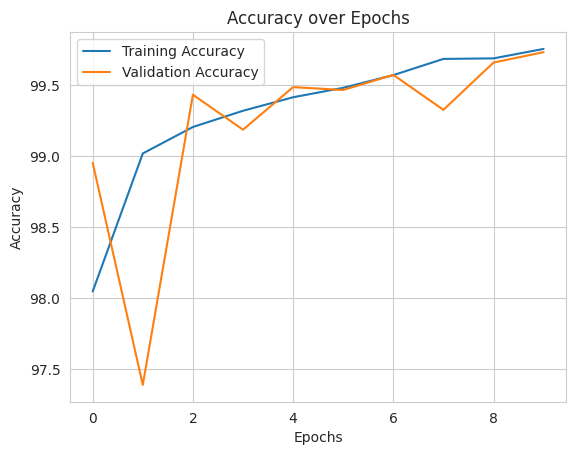

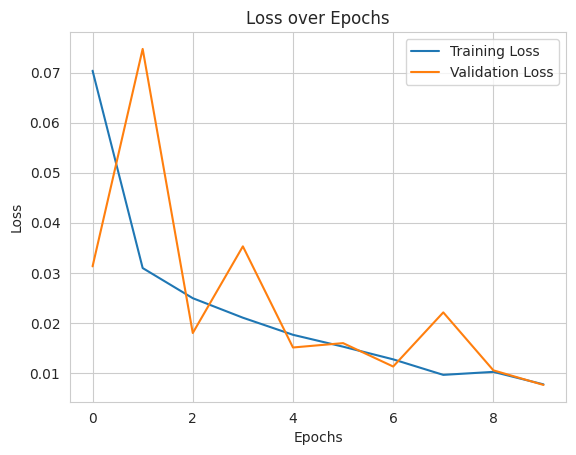

In [15]:
# Lists to store accuracy and error during training
train_accuracies = []
test_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

# Number of epochs for training
num_epochs = 10

# Transfer the model to a CUDA device if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Model training
for epoch in range(num_epochs):
    start_time = time.time()  # Epoch start time

    model.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Developer using tqdm
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        
        # Zeroing gradients
        optimizer.zero_grad()
        
        # Passing data from the model
        outputs = model(images)
        
        # Error calculation
        loss = criterion(outputs, labels)
        
        # Return and update weights
        loss.backward()
        optimizer.step()
        
        # Collect statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Record accuracy and error for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_accuracies.append(epoch_accuracy)
    train_losses.append(epoch_loss)
    
    # Evaluate the model on validation data
    model.eval()  # Evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # There is no need to calculate the gradient in this part
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Loss calculation
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            # Calculation accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    # Calculating the elapsed time for an epoch
    epoch_time = time.time() - start_time

    # Show statistics for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, "
          f"Val Accuracy: {val_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")

# Display a chart of precisions and errors
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.show()

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

This code saves the trained model's weights (state_dict) to a file named `model.pth` using the `torch.save()` function. Here's what it does:

- **`model.state_dict()`**: This method retrieves the learned parameters (weights and biases) of the model.
- **`torch.save()`**: This function saves the model's state_dict to a specified file, in this case, `model.pth`.

After the model is saved, the message `"Model saved!"` will be printed to the console to confirm that the process was successful.

### Explanation:
- **Saving the model**: Storing the model allows you to reload it later without needing to retrain it, which can save both time and computational resources.
- **What is saved**: Only the weights and biases (state_dict) are saved, not the full model architecture. You need to define the model architecture again when loading the weights. 

If you want to load this model later, you can use:

```python
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set model to evaluation mode
```

This ensures that you can continue using the model or fine-tune it later without retraining from scratch.

In [16]:
# Save the trained model
torch.save(model.state_dict(), 'model.pth')
print("Model saved!")

Model saved!


This code evaluates the model's performance on the test dataset and computes the test accuracy. Here's a breakdown of how it works:

Key Steps:
model.eval(): Sets the model to evaluation mode, which disables features like dropout layers that are only used during training.

torch.no_grad(): Disables gradient calculation, which is useful for evaluation as we don’t need to backpropagate and update weights during testing.

Loop over test data:

For each batch in the test data (test_loader), the model makes predictions.
outputs = model(images) generates the model's predictions for the images.
_, predicted = torch.max(outputs, 1) selects the predicted class (the one with the highest output value).
The number of correct predictions is updated by checking if the predicted class matches the true label (predicted == labels).
Accuracy Calculation:

test_correct keeps track of the total number of correct predictions.
test_total is the total number of samples in the test set.
The accuracy is computed as the ratio of correct predictions to total predictions, multiplied by 100 for percentage.
Result:
The test accuracy is printed in the format Test Accuracy: X.XX%, where X.XX is the calculated accuracy percentage.

In [17]:
# Evaluate the model on test data
model.eval()  # Evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():  # There is no need to calculate the gradient in this part
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 99.67%


This code performs model evaluation on the test dataset and computes the classification performance using metrics such as the confusion matrix and classification report.

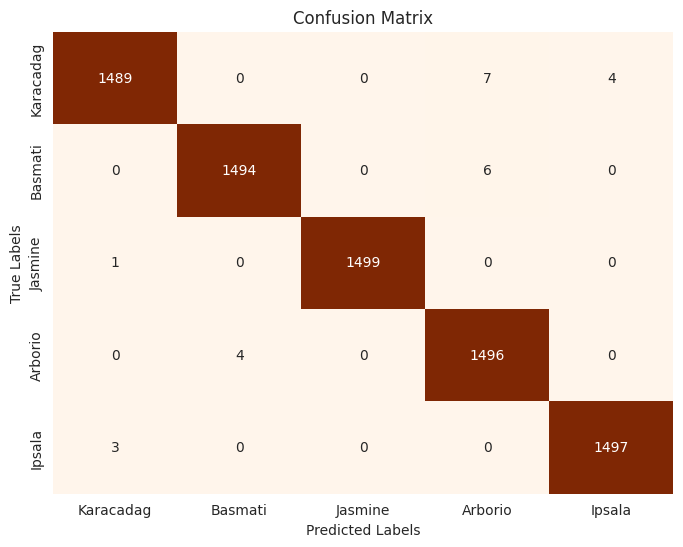


Classification Report:
Detailed Classification Report
              precision    recall  f1-score   support

   Karacadag       1.00      0.99      0.99      1500
     Basmati       1.00      1.00      1.00      1500
     Jasmine       1.00      1.00      1.00      1500
     Arborio       0.99      1.00      0.99      1500
      Ipsala       1.00      1.00      1.00      1500

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



In [18]:
# Lists to store predictions and actual labels
y_pred_classes = []
y_true = []

# Model evaluation on test data
model.eval()  
with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)
        
        # Forecasting with the model
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        
        # Add results to lists
        y_pred_classes.extend(predicted_classes.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Draw a Hipmap from the Confusion Matrix Using Class Names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False, xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Printing a Classification Report
print("\nClassification Report:")
clf_report = classification_report(y_true, y_pred_classes, target_names=classes)
print("="*50)
print("Detailed Classification Report")
print("="*50)
print(clf_report)
print("="*50)
